<a href="https://colab.research.google.com/github/narayanvyas/Arduino-Bluetooth-Relay-Control-With-SoftwareSerial/blob/master/01_ewaste_detection_non_argumented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load Helper Functions

In [2]:
pip install split-folders

In [3]:
# Load the functions from helper.py

!wget https://raw.githubusercontent.com/narayanvyas/ml-helper/master/helper_functions.py

from helper_functions import pred_and_plot, create_tensorboard_callback,make_confusion_matrix, plot_loss_curves, getClassNames, walk_through_dir, compare_historys, unzip_data, unzip_data, calculate_results, removeData

--2021-12-12 04:56:01--  https://raw.githubusercontent.com/narayanvyas/ml-helper/master/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11081 (11K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.82K  --.-KB/s    in 0s      

2021-12-12 04:56:01 (50.4 MB/s) - ‘helper_functions.py’ saved [11081/11081]



Initialize Global Variables

In [1]:
rootPath = '/content/drive/MyDrive/'
folderName = 'spares_processed'


inputFolder = folderName
# outputFolder = folderName
outputFolder = folderName + '_splitted'

train_dir = outputFolder + '/train/'
test_dir = outputFolder + '/test/'

trainingRatio = 0.9
testRatio = 0.1
validationRatio = 0.0

batchSize = 32
epochs = 5
imgSize = (224, 224)

In [4]:
unzip_data(rootPath + folderName + '.zip')

In [5]:
walk_through_dir(folderName)

There are 11 directories and 1 images in 'spares_processed'.
There are 0 directories and 210 images in 'spares_processed/RAM'.
There are 0 directories and 233 images in 'spares_processed/USB'.
There are 0 directories and 228 images in 'spares_processed/Keyboard'.
There are 0 directories and 285 images in 'spares_processed/Speakers'.
There are 0 directories and 283 images in 'spares_processed/Optical Disk Drive'.
There are 0 directories and 288 images in 'spares_processed/PSU'.
There are 0 directories and 296 images in 'spares_processed/Fan'.
There are 0 directories and 272 images in 'spares_processed/Hard Disk'.
There are 0 directories and 291 images in 'spares_processed/Motherboard'.
There are 0 directories and 269 images in 'spares_processed/Monitor'.
There are 0 directories and 269 images in 'spares_processed/Mouse'.


In [6]:
import splitfolders

splitfolders.ratio(inputFolder, output=outputFolder, seed=42, ratio=(trainingRatio, validationRatio, testRatio))

Copying files: 2924 files [00:00, 5716.85 files/s]


In [7]:
import tensorflow as tf

# Load data in from directories and turn it into batches
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=imgSize,
                                                                            label_mode="categorical",
                                                                            batch_size=batchSize)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=imgSize,
                                                                           label_mode="categorical")

Found 2625 files belonging to 11 classes.
Found 297 files belonging to 11 classes.


In [153]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Rescale the data and create data generator instances
# train_datagen = ImageDataGenerator(rescale=1/255.)
# test_datagen = ImageDataGenerator(rescale=1/255.)

# # Load data in from directories and turn it into batches
# train_data = train_datagen.flow_from_directory(train_dir,
#                                                target_size=imgSize,
#                                                batch_size=batchSize,
#                                                class_mode='categorical') # changed to categorical

# test_data = train_datagen.flow_from_directory(test_dir,
#                                               target_size=imgSize,
#                                               batch_size=batchSize,
#                                               class_mode='categorical')

Found 2429 images belonging to 9 classes.
Found 270 images belonging to 9 classes.


In [8]:

class_names = train_data.class_names
class_names

In [54]:
# Create augmented data generator instance
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # note: this is an int not a float
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                  target_size=imgSize,
                                                                  batch_size=batchSize,
                                                                  class_mode='categorical')

Found 1619 images belonging to 6 classes.


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(len(class_names), activation='softmax')
])

model.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

In [11]:
history = model.fit(train_data,
                          epochs=epochs,
                          steps_per_epoch=len(train_data),
                          validation_data=test_data,
                          validation_steps=len(test_data),
                          callbacks=[create_tensorboard_callback("ewaste_detection", "base_model_non_argumented_data")])

Saving TensorBoard log files to: ewaste_detection/base_model_non_argumented_data/20211212-045736
Epoch 1/5
83/83 [==============================] - 16s 58ms/step - loss: 47.2700 - accuracy: 0.1474 - val_loss: 2.5411 - val_accuracy: 0.1953
Epoch 2/5
83/83 [==============================] - 5s 55ms/step - loss: 1.8420 - accuracy: 0.3909 - val_loss: 2.3958 - val_accuracy: 0.2189
Epoch 3/5
83/83 [==============================] - 5s 54ms/step - loss: 1.1445 - accuracy: 0.6495 - val_loss: 2.4894 - val_accuracy: 0.2458
Epoch 4/5
83/83 [==============================] - 5s 53ms/step - loss: 0.5957 - accuracy: 0.8503 - val_loss: 2.8837 - val_accuracy: 0.2626
Epoch 5/5
83/83 [==============================] - 5s 53ms/step - loss: 0.2828 - accuracy: 0.9451 - val_loss: 3.2315 - val_accuracy: 0.2727


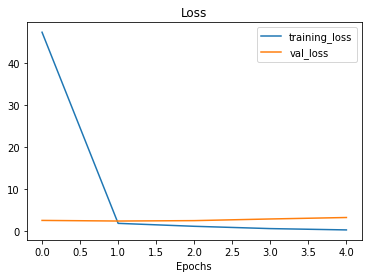

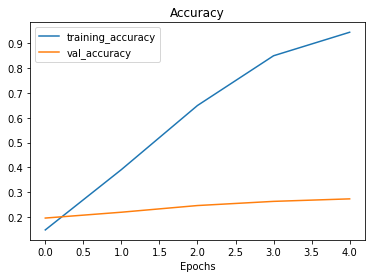

In [12]:
plot_loss_curves(history)

In [13]:

# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take 

10/10 [==============================] - 1s 15ms/step


In [16]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[6, 7, 8, 3, 9, 3, 4, 4, 5, 8]

In [146]:
# Get the class names
class_names = test_data.class_names
class_names

['Fan',
 'Hard Disk',
 'Monitor',
 'Motherboard',
 'Mouse',
 'Optical Disk Drive',
 'PSU',
 'RAM',
 'Speakers']

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.06      0.03      0.04        30
           1       0.11      0.14      0.12        28
           2       0.05      0.09      0.07        23
           3       0.05      0.07      0.06        27
           4       0.13      0.07      0.09        30
           5       0.06      0.04      0.04        27
           6       0.00      0.00      0.00        29
           7       0.05      0.03      0.04        29
           8       0.07      0.14      0.09        21
           9       0.09      0.07      0.08        29
          10       0.12      0.08      0.10        24

    accuracy                           0.07       297
   macro avg       0.07      0.07      0.07       297
weighted avg       0.07      0.07      0.07       297



In [19]:
# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./ewaste_detectiony \
  --name "eWaste Detection" \
  --description "A series of different ML Experiments for eWaste Detection" \
  --one_shot # exits the uploader when upload has finished


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./ewaste_detection

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=dyQ7DeLa4hHs6EKgib5qZ0b4UOHwcO&prompt=consent&access_type=of